In [1]:
import cv2
import numpy as np
from plantcv import plantcv as pcv
import matplotlib.pyplot as plt

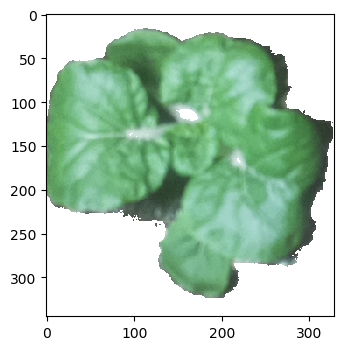

In [2]:
img, path, filename = pcv.readimage("C1_ROI.png")
pcv.params.debug=True
pcv.params.debug_outdir = "output.png"

if np.average(img) < 50:
    pcv.fatal_error("Night Image")
else:
    pass

hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
mask = cv2.inRange(hsv, (36, 25, 25), (100, 255,255))
## slice the green
imask = mask>0
green = np.zeros_like(img, np.uint8)
green[imask] = img[imask]
gray = cv2.cvtColor(green, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray, 0, 10, cv2.THRESH_BINARY)
green[thresh == 0] = 255
img = green
pcv.plot_image(img)

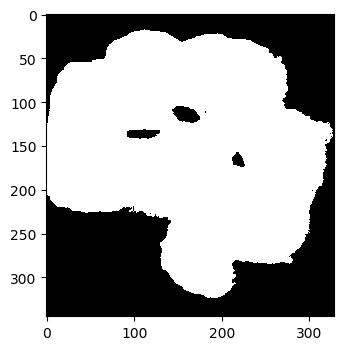

In [3]:
s = pcv.rgb2gray_hsv(rgb_img=img, channel='s')
s_thresh = pcv.threshold.binary(gray_img=s, threshold=40, max_value=50, object_type='light')
s_mblur = pcv.median_blur(gray_img=s_thresh, ksize=5)
s_cnt = pcv.median_blur(gray_img=s_thresh, ksize=5)
pcv.plot_image(s_thresh)

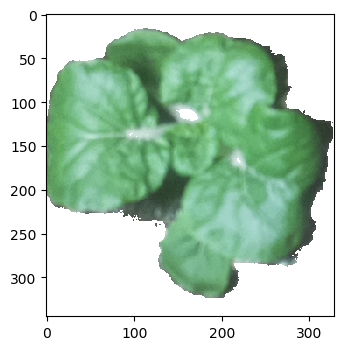

In [5]:
# Convert RGB to LAB and extract the Blue channel

# Input:
#   rgb_img - RGB image data 
#   channel- Split by 'l' (lightness), 'a' (green-magenta), or 'b' (blue-yellow) channel
b = pcv.rgb2gray_lab(rgb_img=img, channel='b')

# Threshold the blue image
b_thresh = pcv.threshold.binary(gray_img=b, threshold=120, max_value=255, 
                                object_type='light')
b_cnt = pcv.threshold.binary(gray_img=b, threshold=120, max_value=255, 
                             object_type='light')
bs = pcv.logical_or(bin_img1=s_mblur, bin_img2=b_cnt)
masked = pcv.apply_mask(img=img, mask=bs, mask_color='white')
pcv.plot_image(masked)

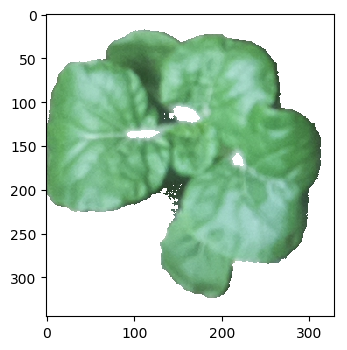

In [7]:
# Convert RGB to LAB and extract the Green-Magenta and Blue-Yellow channels
masked_a = pcv.rgb2gray_lab(rgb_img=masked, channel='a')
masked_b = pcv.rgb2gray_lab(rgb_img=masked, channel='b')

# Threshold the green-magenta and blue images
maskeda_thresh = pcv.threshold.binary(gray_img=masked_a, threshold=115, 
                                  max_value=255, object_type='dark')
maskeda_thresh1 = pcv.threshold.binary(gray_img=masked_a, threshold=135, 
                                       max_value=255, object_type='light')

#maskedb_thresh = pcv.threshold.binary(gray_img=masked_b, threshold=125, 
                                     # max_value=255, object_type='light')

# Join the thresholded saturation and blue-yellow images (OR)
ab1 = pcv.logical_or(bin_img1=maskeda_thresh, bin_img2=maskeda_thresh1)
#ab = pcv.logical_or(bin_img1=maskeda_thresh1, bin_img2=ab1)

# Fill small objects
# Inputs: 
#   bin_img - Binary image data 
#   size - Minimum object area size in pixels (must be an integer), and smaller objects will be filled
ab_fill = pcv.fill(bin_img=ab1, size=100)

# Apply mask (for VIS images, mask_color=white)
masked2 = pcv.apply_mask(img=masked, mask=ab_fill, mask_color='white')
pcv.plot_image(masked2)

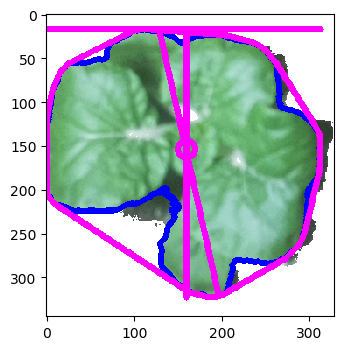

In [11]:
# Identify objects
id_objects, obj_hierarchy = pcv.find_objects(masked2, ab_fill)
roi1, roi_hierarchy= pcv.roi.rectangle(img=masked2, x=0, y=0, h=345, w=329)
roi_objects, hierarchy3, kept_mask, obj_area = pcv.roi_objects(img=img, roi_contour=roi1, 
                                                               roi_hierarchy=roi_hierarchy, 
                                                               object_contour=id_objects, 
                                                               obj_hierarchy=obj_hierarchy,
                                                               roi_type='partial')
obj, mask = pcv.object_composition(img=img, contours=roi_objects, hierarchy=hierarchy3)
shape_img = pcv.analyze_object(img=img, obj=obj, mask=mask)
pcv.plot_image(shape_img)

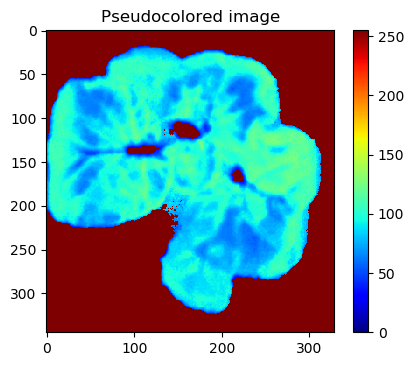

In [12]:
masked_image = pcv.apply_mask(s, mask, 'white')
pseudocolored_img = pcv.visualize.pseudocolor(gray_img=masked_image, mask=None, cmap='jet')

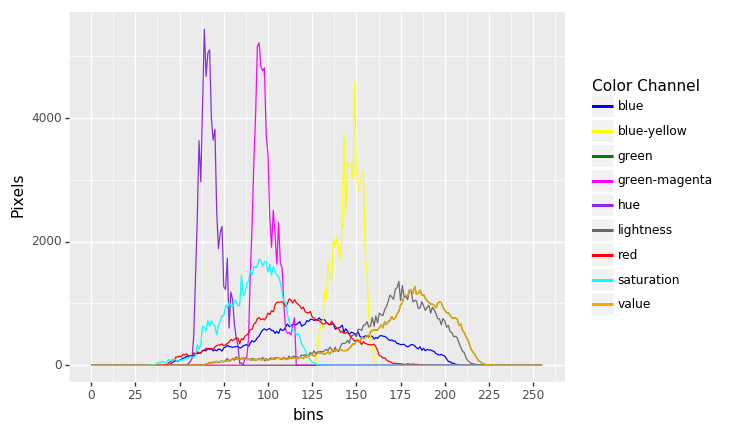

<ggplot: (8794772311111)>


In [13]:
color_histogram = pcv.analyze_color(rgb_img=img, mask=kept_mask, hist_plot_type='all')
pcv.plot_image(color_histogram)

In [14]:
pcv.print_results(filename="result_my.txt")
cv2.imwrite('shape_img_my.png',shape_img) 
pseudocolored_img.savefig('pseudocolored_img_my.png')
pcv.print_image(color_histogram, "color_histogram_my.png")

/home/ajay/anaconda3/lib/python3.6/site-packages/plotnine/ggplot.py:706: UserWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units))
/home/ajay/anaconda3/lib/python3.6/site-packages/plotnine/ggplot.py:707: UserWarning: Filename: color_histogram_my.png
  warn('Filename: {}'.format(filename))
